# AA with excluding/include AAs

In [1]:
import json
import os
from copy import deepcopy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

2025-01-15 10:42:32.647829: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-15 10:42:32.655385: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736955752.664096  112707 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736955752.666692  112707 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-15 10:42:32.675843: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## dataset

In [2]:
infile = '/home/yuan/results/epitope/epi_top_features.txt'
df = pd.read_csv(infile, sep='\t', header=0, index_col=None)
# balance the number of epitopes and non-epitopes
# shuffle rows
df = df.sample(frac=1)
df.head()

,seq,label,mean_hydro_ph7,mean_hydro,mean_polar,mean_polar_stab,mean_VDWV,median_hydro_ph7,median_hydro,median_polar,...,has_C,has_I,has_L,has_K,has_F,has_P,has_S,has_T,has_Y,has_V
6862,WCIEQTLYFKD,0,36.272727,1.227273,8.009091,0.205455,4.431818,49.0,1.15,6.2,...,1,1,1,1,1,0,0,1,1,0
548768,LLSPGTALIL,0,49.000000,1.107000,6.770000,0.127700,2.792000,69.0,1.53,6.6,...,0,1,1,0,0,1,1,1,0,0
1666431,AHGSTLAGVNVGEQY,0,22.733333,0.581333,8.580000,0.114733,2.534000,8.0,0.47,9.0,...,0,0,1,0,0,0,1,1,1,1
2854945,LIKESGTDD,0,4.444444,0.717778,9.611111,0.124667,2.923333,-5.0,0.46,9.2,...,0,1,1,1,0,0,1,1,0,0
2894340,YYMSNDIPYTFHQDN,1,17.066667,0.984000,8.706667,0.185333,4.048000,8.0,0.61,8.6,...,0,1,0,0,1,1,1,1,1,0


In [3]:
%load_ext autoreload
%autoreload 2

from seq.my_ann import MyAnn

## filter I: 
- Cys not in seq or Val in seq or Leu in seq. The condition could cover most epitopes

In [4]:
def fn(x):
    if x['label'] == 1:
        seq = str(x['seq'])
        if ('C' not in seq) or 'V' in seq or 'L' in seq:
            return True
        return False
    return True
select = df.apply(fn, axis=1)
print(select.value_counts())

# keep epitopes having Val or Leu, and without Cys
sub_df = df.loc[select]
# sub_df = sub_df.drop(['has_C', 'has_V', 'has_L'], axis=1)
print(sub_df.shape)

True     3434619
False      23619
Name: count, dtype: int64
(3434619, 50)


In [5]:
# prepare 
c = MyAnn()
c.get_xy(sub_df)

X: (3434619, 48) float16
y: (3434619,) float16
labels: Counter({np.float16(1.0): 1841623, np.float16(0.0): 1592996})
train data: (1923386, 48) (1923386,)
validate data: (824309, 48) (824309,)
test data (686924, 48) (686924,)


In [6]:
# train model
c.declare_model()
c.train(epochs=10)

I0000 00:00:1736955783.879311  112707 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1192 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        25,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,433 (290.75 KB)

 Trainable params: 74,433 (290.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


I0000 00:00:1736955785.284601  112851 service.cc:148] XLA service 0x7224040156c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736955785.284624  112851 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-01-15 10:43:05.306802: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736955785.392360  112851 cuda_dnn.cc:529] Loaded cuDNN version 90300


   83/60106 ━━━━━━━━━━━━━━━━━━━━ 1:53 2ms/step - accuracy: 0.5935 - auc: 0.6189 - loss: 0.6779 - mse: 0.2412 - precision: 0.6146 - recall: 0.6384   

I0000 00:00:1736955785.981775  112851 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60106/60106 ━━━━━━━━━━━━━━━━━━━━ 114s 2ms/step - accuracy: 0.6687 - auc: 0.7240 - loss: 0.6070 - mse: 0.2101 - precision: 0.6619 - recall: 0.7806 - val_accuracy: 0.6904 - val_auc: 0.7541 - val_loss: 0.5824 - val_mse: 0.1997 - val_precision: 0.6732 - val_recall: 0.8225
Epoch 2/10
60106/60106 ━━━━━━━━━━━━━━━━━━━━ 104s 2ms/step - accuracy: 0.6899 - auc: 0.7507 - loss: 0.5858 - mse: 0.2009 - precision: 0.6783 - recall: 0.8019 - val_accuracy: 0.6988 - val_auc: 0.7657 - val_loss: 0.5738 - val_mse: 0.1960 - val_precision: 0.6765 - val_recall: 0.8413
Epoch 3/10
60106/60106 ━━━━━━━━━━━━━━━━━━━━ 115s 2ms/step - accuracy: 0.6959 - auc: 0.7580 - loss: 0.5793 - mse: 0.1981 - precision: 0.6851 - recall: 0.8009 - val_accuracy: 0.7040 - val_auc: 0.7690 - val_loss: 0.5686 - val_mse: 0.1939 - val_precision: 0.6835 - val_recall: 0.8352
Epoch 4/10
60106/60106 ━━━━━━━━━━━━━━━━━━━━ 121s 2ms/step - accuracy: 0.6980 - auc: 0.7612 - loss: 0.5764 - mse: 0.1968 - precision: 0.6877 - recall: 0.8000 - val_accuracy

,accuracy,auc,loss,mse,precision,recall,val_accuracy,val_auc,val_loss,val_mse,val_precision,val_recall
0,0.675728,0.733623,0.599475,0.206899,0.666248,0.791597,0.690370,0.754133,0.582409,0.199734,0.673173,0.822549
1,0.691983,0.753064,0.583711,0.199927,0.680395,0.802195,0.698803,0.765670,0.573756,0.196017,0.676464,0.841268
2,0.696672,0.759272,0.578336,0.197608,0.686102,0.800244,0.703952,0.769014,0.568638,0.193890,0.683520,0.835223
3,0.698602,0.762092,0.575798,0.196527,0.688570,0.799186,0.705209,0.771159,0.566579,0.193012,0.692915,0.809672
4,0.700169,0.763870,0.574320,0.195854,0.690190,0.799546,0.707981,0.773969,0.562813,0.191433,0.699814,0.798542
5,0.701117,0.765193,0.573059,0.195324,0.691705,0.798159,0.708392,0.774176,0.562867,0.191372,0.693419,0.818780
6,0.702047,0.766183,0.572216,0.194929,0.692558,0.798723,0.709600,0.775684,0.561475,0.190805,0.697700,0.809968
7,0.702544,0.766950,0.571428,0.194623,0.692960,0.799187,0.708641,0.775600,0.562354,0.191231,0.692694,0.821835
8,0.703082,0.767606,0.571007,0.194399,0.693751,0.798629,0.710021,0.776679,0.560605,0.190484,0.694967,0.819503
9,0.703289,0.767877,0.570707,0.194286,0.693958,0.798707,0.709358,0.776249,0.562081,0.191043,0.697632,0.809370


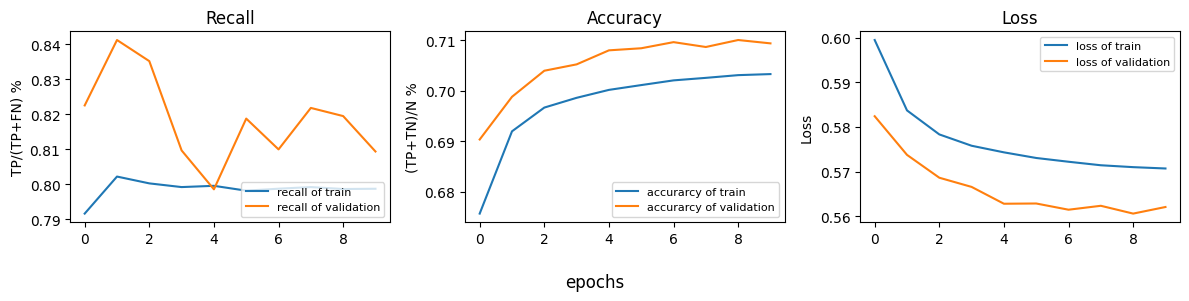

In [7]:
# evaluate model
c.plot_acc_recall()

21467/21467 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step - accuracy: 0.7083 - auc: 0.7755 - loss: 0.5627 - mse: 0.1913 - precision: 0.6962 - recall: 0.8080  
{'accuracy': 0.7086883187294006, 'auc': 0.7756507396697998, 'loss': 0.5626714825630188, 'mse': 0.19129006564617157, 'precision': 0.6966618299484253, 'recall': 0.8084122538566589}
21467/21467 ━━━━━━━━━━━━━━━━━━━━ 11s 496us/step
[[0.7493138]
 [0.3853569]
 [0.761561 ]]


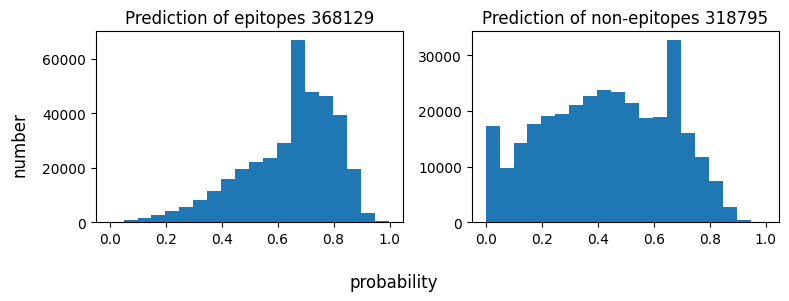

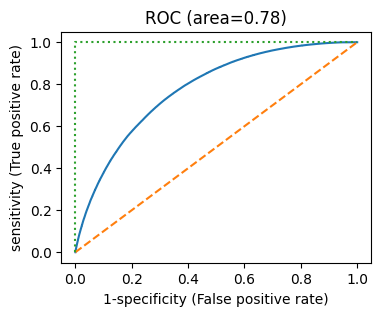

In [8]:
# evaluate model using test data
c.test()
c.plot_prob()
c.plot_roc()

In [9]:
# save entire model
c.save_model('../models/epitopes_ann_notCys_or_Val_or_Leu.keras')

<Sequential name=sequential, built=True>

### remaining

In [46]:
def fn(x):
    if x['label'] == 1:
        seq = str(x['seq'])
        if ('C' not in seq) or 'V' in seq or 'L' in seq:
            return False
        return True
    return True
select = df.apply(fn, axis=1)
print(select.value_counts())

# keep epitopes having Val or Leu, and without Cys
sub_df = df.loc[select]
print(sub_df.shape)

False    1841623
True     1616615
Name: count, dtype: int64
(1616615, 50)


In [47]:
# prepare 
c = MyAnn()
c.get_xy(sub_df)

X: (1616615, 48) float16
y: (1616615,) float16
labels: Counter({np.float16(0.0): 1592996, np.float16(1.0): 23619})
train data: (905304, 48) (905304,)
validate data: (387988, 48) (387988,)
test data (323323, 48) (323323,)


In [48]:
# train model
c.declare_model()
c.train(epochs=10)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 512)            │        25,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,433 (290.75 KB)

 Trainable params: 74,433 (290.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
28291/28291 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - accuracy: 0.9859 - auc: 0.9804 - loss: 0.0328 - mse: 0.0102 - precision: 0.5728 - recall: 0.2189 - val_accuracy: 0.9879 - val_auc: 0.9894 - val_loss: 0.0278 - val_mse: 0.0089 - val_precision: 0.6326 - val_recall: 0.4176
Epoch 2/10
28291/28291 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - accuracy: 0.9873 - auc: 0.9879 - loss: 0.0287 - mse: 0.0091 - precision: 0.6547 - recall: 0.2919 - val_accuracy: 0.9881 - val_auc: 0.9902 - val_loss: 0.0274 - val_mse: 0.0087 - val_precision: 0.6665 - val_recall: 0.3817
Epoch 3/10
28291/28291 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - accuracy: 0.9875 - auc: 0.9887 - loss: 0.0281 - mse: 0.0089 - precision: 0.6636 - recall: 0.3053 - val_accuracy: 0.9883 - val_auc: 0.9899 - val_loss: 0.0271 - val_mse: 0.0086 - val_precision: 0.6507 - val_recall: 0.4360
Epoch 4/10
28291/28291 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.9878 - auc: 0.9896 - loss: 0.0274 - mse: 0.0087 - precision: 0.6712 - recall: 0.3297 - 

,accuracy,auc,loss,mse,precision,recall,val_accuracy,val_auc,val_loss,val_mse,val_precision,val_recall
0,0.986773,0.986130,0.029926,0.009522,0.623455,0.257201,0.987891,0.989438,0.027761,0.008875,0.632615,0.417559
1,0.987320,0.988328,0.028453,0.009076,0.658079,0.289304,0.988121,0.990209,0.027404,0.008693,0.666462,0.381738
2,0.987600,0.988577,0.028014,0.008904,0.669021,0.312631,0.988286,0.989891,0.027148,0.008600,0.650681,0.435997
3,0.987652,0.988973,0.027732,0.008805,0.667810,0.321332,0.988237,0.989876,0.026959,0.008553,0.678222,0.377875
4,0.987696,0.988868,0.027710,0.008767,0.674630,0.317732,0.987469,0.990554,0.026856,0.008608,0.697862,0.257946
5,0.987785,0.988890,0.027506,0.008707,0.676006,0.327558,0.988345,0.990049,0.026477,0.008387,0.674087,0.398771
6,0.987888,0.989054,0.027506,0.008690,0.683802,0.330258,0.988283,0.990665,0.026598,0.008444,0.678472,0.383494
7,0.987826,0.988634,0.027512,0.008698,0.681711,0.325158,0.988613,0.989621,0.026647,0.008392,0.666667,0.448464
8,0.987891,0.988562,0.027558,0.008661,0.686145,0.327633,0.987587,0.989708,0.026796,0.008506,0.718548,0.253731
9,0.987972,0.988989,0.027314,0.008607,0.688532,0.334608,0.987440,0.990943,0.026866,0.008664,0.741481,0.221598


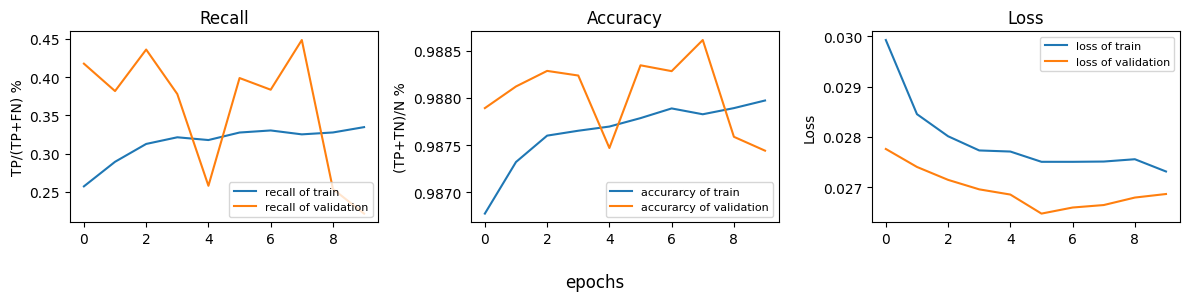

In [49]:
# evaluate model
c.plot_acc_recall()

10104/10104 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.9880 - auc: 0.9907 - loss: 0.0264 - mse: 0.0085 - precision: 0.7644 - recall: 0.2176 
{'accuracy': 0.9878202080726624, 'auc': 0.9909785985946655, 'loss': 0.02634352818131447, 'mse': 0.008464572951197624, 'precision': 0.735251784324646, 'recall': 0.22256097197532654}
10104/10104 ━━━━━━━━━━━━━━━━━━━━ 4s 418us/step
[[5.7177102e-30]
 [0.0000000e+00]
 [0.0000000e+00]]


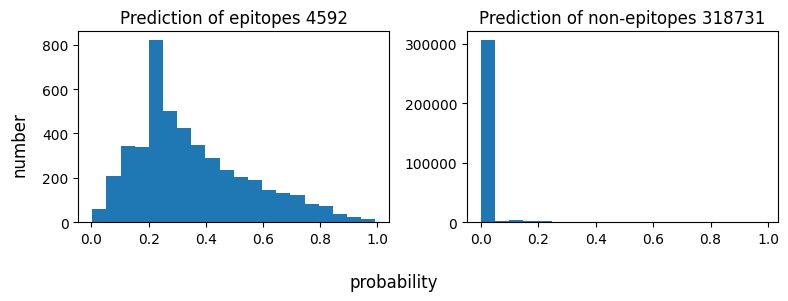

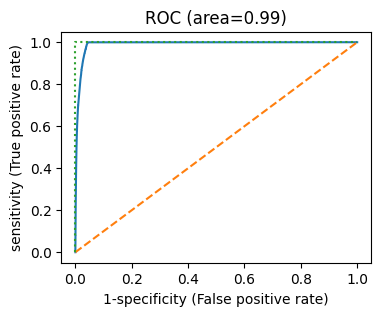

In [50]:
# evaluate model using test data
c.test()
c.plot_prob()
c.plot_roc()

In [51]:
# save entire model
c.save_model('../models/epitopes_ann_notCys_or_Val_or_Leu_remaining.keras')

<Sequential name=sequential_7, built=True>

## filter II: 
- Cys not in seq and (Val in seq or Leu in seq)

In [16]:
def fn(x):
    if x['label'] == 1:
        seq = str(x['seq'])
        if ('C' not in seq) and ('V' in seq or 'L' in seq):
            return True
        return False
    return True
select = df.apply(fn, axis=1)
print(select.value_counts())

# keep epitopes having Val or Leu, and without Cys
sub_df = df.loc[select]
print(sub_df.shape)

True     3043115
False     415123
Name: count, dtype: int64
(3043115, 50)


In [17]:
# prepare 
c = MyAnn()
c.get_xy(sub_df)

X: (3043115, 48) float16
y: (3043115,) float16
labels: Counter({np.float16(0.0): 1592996, np.float16(1.0): 1450119})
train data: (1704144, 48) (1704144,)
validate data: (730348, 48) (730348,)
test data (608623, 48) (608623,)


In [18]:
# train model
c.declare_model()
c.train(epochs=10)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 512)            │        25,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,433 (290.75 KB)

 Trainable params: 74,433 (290.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
53255/53255 ━━━━━━━━━━━━━━━━━━━━ 105s 2ms/step - accuracy: 0.7218 - auc: 0.8035 - loss: 0.5031 - mse: 0.1746 - precision: 0.6667 - recall: 0.8319 - val_accuracy: 0.7365 - val_auc: 0.8238 - val_loss: 0.4853 - val_mse: 0.1673 - val_precision: 0.6711 - val_recall: 0.8766
Epoch 2/10
53255/53255 ━━━━━━━━━━━━━━━━━━━━ 100s 2ms/step - accuracy: 0.7370 - auc: 0.8211 - loss: 0.4876 - mse: 0.1680 - precision: 0.6814 - recall: 0.8415 - val_accuracy: 0.7467 - val_auc: 0.8308 - val_loss: 0.4786 - val_mse: 0.1642 - val_precision: 0.6926 - val_recall: 0.8421
Epoch 3/10
53255/53255 ━━━━━━━━━━━━━━━━━━━━ 100s 2ms/step - accuracy: 0.7421 - auc: 0.8261 - loss: 0.4830 - mse: 0.1659 - precision: 0.6888 - recall: 0.8364 - val_accuracy: 0.7490 - val_auc: 0.8336 - val_loss: 0.4750 - val_mse: 0.1626 - val_precision: 0.6995 - val_recall: 0.8296
Epoch 4/10
53255/53255 ━━━━━━━━━━━━━━━━━━━━ 94s 2ms/step - accuracy: 0.7439 - auc: 0.8285 - loss: 0.4809 - mse: 0.1650 - precision: 0.6926 - recall: 0.8310

,accuracy,auc,loss,mse,precision,recall,val_accuracy,val_auc,val_loss,val_mse,val_precision,val_recall
0,0.727869,0.810887,0.496263,0.171840,0.671062,0.841208,0.736497,0.823776,0.485290,0.167300,0.671077,0.876606
1,0.738147,0.822213,0.486536,0.167519,0.682961,0.840707,0.746697,0.830791,0.478640,0.164202,0.692604,0.842100
2,0.742482,0.826311,0.482819,0.165834,0.689632,0.835597,0.748991,0.833550,0.474998,0.162614,0.699467,0.829622
3,0.744012,0.828354,0.481013,0.165009,0.693175,0.830246,0.750623,0.834634,0.473354,0.161961,0.701357,0.830022
4,0.745159,0.829311,0.479911,0.164553,0.695074,0.828705,0.751450,0.835927,0.472742,0.161631,0.699918,0.837321
5,0.745696,0.830057,0.479386,0.164287,0.695720,0.828745,0.751932,0.836182,0.471822,0.161294,0.702581,0.831212
6,0.746052,0.830519,0.478869,0.164079,0.696591,0.827426,0.752343,0.836762,0.471406,0.161067,0.705845,0.823312
7,0.746305,0.831030,0.478359,0.163878,0.696900,0.827437,0.749930,0.836868,0.473267,0.161963,0.689097,0.865737
8,0.746878,0.831261,0.478401,0.163829,0.697515,0.827709,0.751521,0.836962,0.472714,0.161631,0.696544,0.847854
9,0.747001,0.831624,0.477886,0.163633,0.698078,0.826478,0.752974,0.837439,0.470501,0.160651,0.716830,0.795953


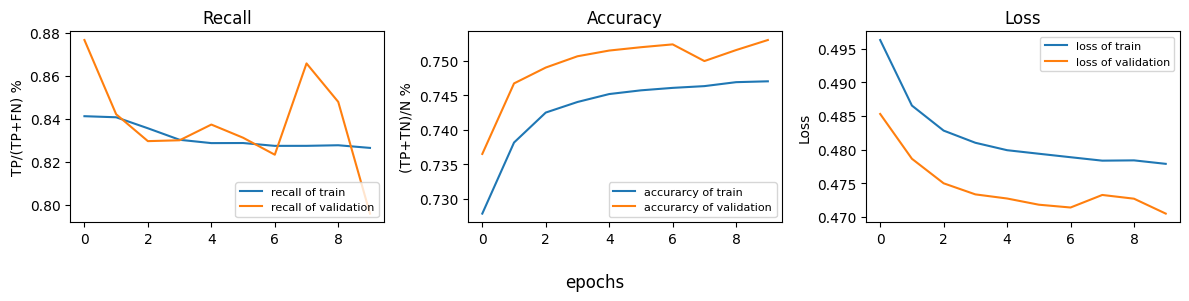

In [19]:
# evaluate model
c.plot_acc_recall()

19020/19020 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step - accuracy: 0.7517 - auc: 0.8356 - loss: 0.4725 - mse: 0.1615 - precision: 0.7163 - recall: 0.7945
{'accuracy': 0.7519433498382568, 'auc': 0.8360992670059204, 'loss': 0.4719642698764801, 'mse': 0.16125254333019257, 'precision': 0.7161412239074707, 'recall': 0.7946739196777344}
19020/19020 ━━━━━━━━━━━━━━━━━━━━ 8s 410us/step
[[0.66030216]
 [0.6689096 ]
 [0.8737669 ]]


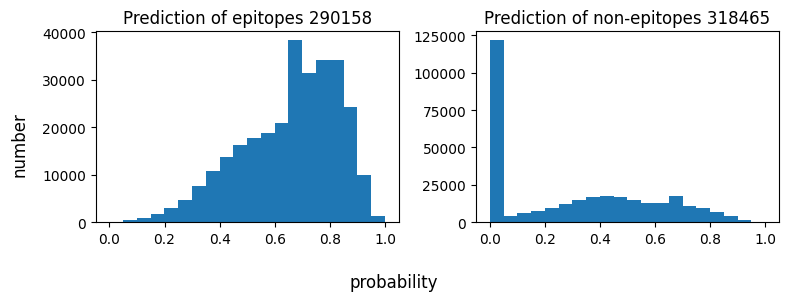

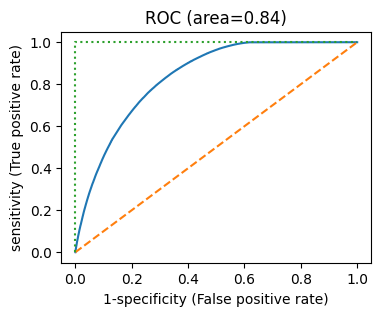

In [20]:
# evaluate model using test data
c.test()
c.plot_prob()
c.plot_roc()

In [21]:
# save entire model
c.save_model('../models/epitopes_ann_notCys_and_Val_or_Leu.keras')

<Sequential name=sequential_2, built=True>

### the remaining data


In [40]:
def fn(x):
    if x['label'] == 1:
        seq = str(x['seq'])
        if ('C' not in seq) and ('V' in seq or 'L' in seq):
            return False
        return True
    return True
select = df.apply(fn, axis=1)
print(select.value_counts())

# keep epitopes having Val or Leu, and without Cys
sub_df = df.loc[select]
print(sub_df.shape)

True     2008119
False    1450119
Name: count, dtype: int64
(2008119, 50)


In [41]:
# prepare 
c = MyAnn()
c.get_xy(sub_df)

X: (2008119, 48) float16
y: (2008119,) float16
labels: Counter({np.float16(0.0): 1592996, np.float16(1.0): 415123})
train data: (1124546, 48) (1124546,)
validate data: (481949, 48) (481949,)
test data (401624, 48) (401624,)


In [42]:
# train model
c.declare_model()
c.train(epochs=10)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 512)            │        25,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,433 (290.75 KB)

 Trainable params: 74,433 (290.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
35143/35143 ━━━━━━━━━━━━━━━━━━━━ 70s 2ms/step - accuracy: 0.8390 - auc: 0.8950 - loss: 0.3069 - mse: 0.1049 - precision: 0.6308 - recall: 0.5322 - val_accuracy: 0.8546 - val_auc: 0.9122 - val_loss: 0.2863 - val_mse: 0.0970 - val_precision: 0.6520 - val_recall: 0.6333
Epoch 2/10
35143/35143 ━━━━━━━━━━━━━━━━━━━━ 64s 2ms/step - accuracy: 0.8530 - auc: 0.9107 - loss: 0.2893 - mse: 0.0979 - precision: 0.6511 - recall: 0.6294 - val_accuracy: 0.8594 - val_auc: 0.9183 - val_loss: 0.2790 - val_mse: 0.0941 - val_precision: 0.6677 - val_recall: 0.6347
Epoch 3/10
35143/35143 ━━━━━━━━━━━━━━━━━━━━ 70s 2ms/step - accuracy: 0.8585 - auc: 0.9156 - loss: 0.2829 - mse: 0.0952 - precision: 0.6538 - recall: 0.6730 - val_accuracy: 0.8636 - val_auc: 0.9209 - val_loss: 0.2752 - val_mse: 0.0923 - val_precision: 0.6568 - val_recall: 0.7103
Epoch 4/10
35143/35143 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - accuracy: 0.8611 - auc: 0.9179 - loss: 0.2797 - mse: 0.0939 - precision: 0.6553 - recall: 0.6929 - 

,accuracy,auc,loss,mse,precision,recall,val_accuracy,val_auc,val_loss,val_mse,val_precision,val_recall
0,0.845480,0.903162,0.297693,0.101515,0.643138,0.569196,0.854582,0.912173,0.286333,0.096967,0.652034,0.633258
1,0.854754,0.912230,0.287142,0.097019,0.650980,0.642818,0.859444,0.918272,0.279011,0.094104,0.667735,0.634695
2,0.859350,0.916198,0.282045,0.094837,0.654475,0.678696,0.863637,0.920940,0.275209,0.092308,0.656815,0.710348
3,0.861910,0.918443,0.279017,0.093570,0.656784,0.696962,0.866303,0.923401,0.272418,0.091266,0.662397,0.718111
4,0.863015,0.919800,0.277117,0.092801,0.657755,0.704830,0.865525,0.924160,0.270473,0.090538,0.654294,0.738583
5,0.864159,0.920581,0.276112,0.092335,0.660204,0.708035,0.868146,0.925343,0.268534,0.089665,0.669052,0.714441
6,0.865020,0.921471,0.274962,0.091837,0.661619,0.711855,0.866453,0.924585,0.272539,0.091110,0.655063,0.745279
7,0.865519,0.921828,0.274410,0.091602,0.662144,0.715035,0.867810,0.925870,0.267866,0.089423,0.656849,0.752569
8,0.865672,0.922326,0.273719,0.091335,0.661852,0.717518,0.868426,0.926086,0.268068,0.089442,0.661037,0.743801
9,0.866187,0.922456,0.273607,0.091251,0.663618,0.716715,0.868704,0.926519,0.266377,0.088887,0.660127,0.749774


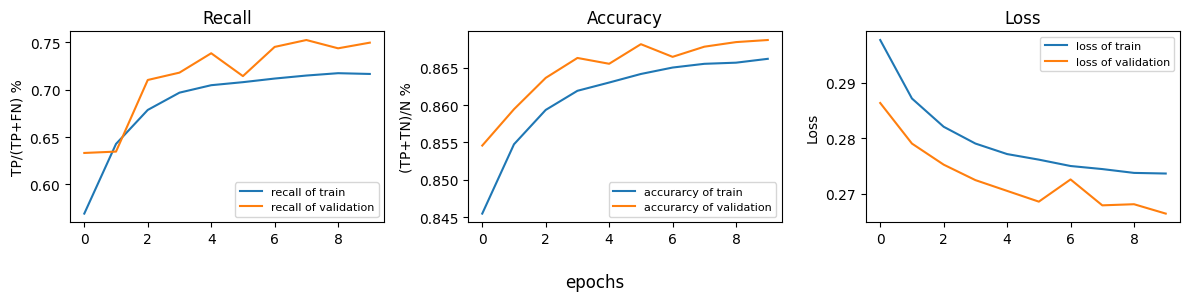

In [43]:
# evaluate model
c.plot_acc_recall()

12551/12551 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.8678 - auc: 0.9262 - loss: 0.2668 - mse: 0.0891 - precision: 0.6575 - recall: 0.7503  
{'accuracy': 0.8683320879936218, 'auc': 0.9265087842941284, 'loss': 0.2664038836956024, 'mse': 0.08890695869922638, 'precision': 0.6590774655342102, 'recall': 0.750756561756134}
12551/12551 ━━━━━━━━━━━━━━━━━━━━ 5s 356us/step
[[0.        ]
 [0.3315474 ]
 [0.31972373]]


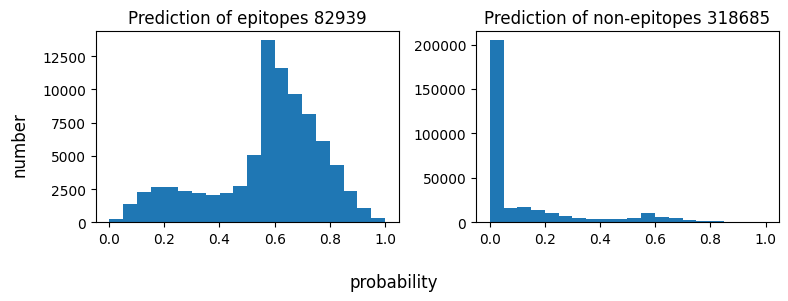

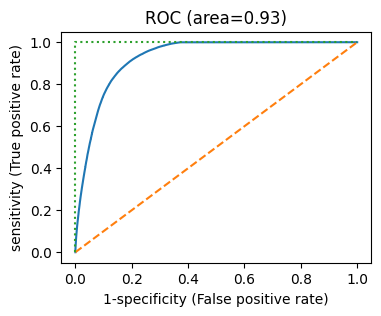

In [44]:
# evaluate model using test data
c.test()
c.plot_prob()
c.plot_roc()

In [45]:
# save entire model
c.save_model('../models/epitopes_ann_notCys_and_Val_or_Leu_remaining.keras')

<Sequential name=sequential_6, built=True>

## filter III: 
- Cys not in seq and and Val in seq and Leu in seq

### the one

In [26]:
def fn(x):
    if x['label'] == 1:
        seq = str(x['seq'])
        if ('C' not in seq) and 'V' in seq and 'L' in seq:
            return True
        return False
    return True
select = df.apply(fn, axis=1)
print(select.value_counts())

# keep epitopes having Val or Leu, and without Cys
sub_df = df.loc[select]
print(sub_df.shape)

True     2263244
False    1194994
Name: count, dtype: int64
(2263244, 50)


In [27]:
# prepare 
c = MyAnn()
c.get_xy(sub_df)

X: (2263244, 48) float16
y: (2263244,) float16
labels: Counter({np.float16(0.0): 1592996, np.float16(1.0): 670248})
train data: (1267416, 48) (1267416,)
validate data: (543179, 48) (543179,)
test data (452649, 48) (452649,)


In [28]:
# train model
c.declare_model()
c.train(epochs=10)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 512)            │        25,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,433 (290.75 KB)

 Trainable params: 74,433 (290.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
39607/39607 ━━━━━━━━━━━━━━━━━━━━ 76s 2ms/step - accuracy: 0.8482 - auc: 0.9228 - loss: 0.2811 - mse: 0.0969 - precision: 0.6841 - recall: 0.9064 - val_accuracy: 0.8586 - val_auc: 0.9323 - val_loss: 0.2686 - val_mse: 0.0919 - val_precision: 0.7162 - val_recall: 0.8646
Epoch 2/10
39607/39607 ━━━━━━━━━━━━━━━━━━━━ 72s 2ms/step - accuracy: 0.8554 - auc: 0.9297 - loss: 0.2723 - mse: 0.0934 - precision: 0.6963 - recall: 0.9072 - val_accuracy: 0.8586 - val_auc: 0.9332 - val_loss: 0.2673 - val_mse: 0.0914 - val_precision: 0.6991 - val_recall: 0.9164
Epoch 3/10
39607/39607 ━━━━━━━━━━━━━━━━━━━━ 81s 2ms/step - accuracy: 0.8566 - auc: 0.9309 - loss: 0.2709 - mse: 0.0927 - precision: 0.6995 - recall: 0.9053 - val_accuracy: 0.8586 - val_auc: 0.9334 - val_loss: 0.2677 - val_mse: 0.0915 - val_precision: 0.6974 - val_recall: 0.9217
Epoch 4/10
39607/39607 ━━━━━━━━━━━━━━━━━━━━ 76s 2ms/step - accuracy: 0.8565 - auc: 0.9311 - loss: 0.2711 - mse: 0.0928 - precision: 0.6999 - recall: 0.9013 - 

,accuracy,auc,loss,mse,precision,recall,val_accuracy,val_auc,val_loss,val_mse,val_precision,val_recall
0,0.851717,0.926320,0.276133,0.094998,0.688810,0.910854,0.858597,0.932279,0.268634,0.091918,0.716168,0.864569
1,0.855713,0.930020,0.271986,0.093209,0.697215,0.906525,0.858627,0.933216,0.267337,0.091365,0.699138,0.916363
2,0.856429,0.930928,0.270987,0.092781,0.699540,0.903187,0.858553,0.933395,0.267710,0.091529,0.697390,0.921728
3,0.857090,0.931441,0.270403,0.092508,0.701140,0.901940,0.859763,0.933770,0.268034,0.091531,0.700839,0.917514
4,0.857305,0.931709,0.270100,0.092376,0.701745,0.901274,0.860849,0.934497,0.265485,0.090583,0.709676,0.896140
5,0.857705,0.932110,0.269676,0.092199,0.702808,0.900246,0.860403,0.934753,0.265660,0.090625,0.702297,0.916556
6,0.857696,0.932266,0.269541,0.092130,0.703393,0.898349,0.859409,0.934869,0.266459,0.090971,0.696196,0.930884
7,0.858117,0.932554,0.269214,0.091972,0.704139,0.898469,0.860852,0.935045,0.265138,0.090423,0.704180,0.913157
8,0.858174,0.932619,0.269084,0.091922,0.704278,0.898370,0.861186,0.935082,0.268635,0.091617,0.703926,0.915908
9,0.858292,0.932780,0.268958,0.091854,0.704839,0.897308,0.862559,0.935484,0.264727,0.090124,0.724248,0.864451


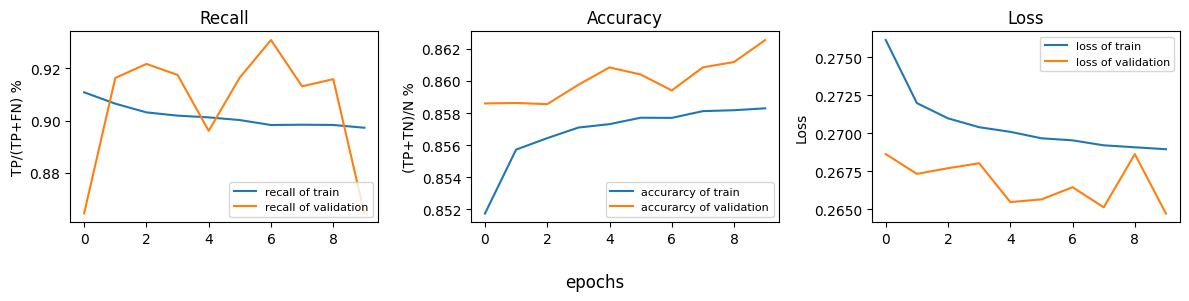

In [29]:
# evaluate model
c.plot_acc_recall()

14146/14146 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - accuracy: 0.8630 - auc: 0.9350 - loss: 0.2652 - mse: 0.0903 - precision: 0.7266 - recall: 0.8628
{'accuracy': 0.8623834252357483, 'auc': 0.9347401857376099, 'loss': 0.26575228571891785, 'mse': 0.09048973768949509, 'precision': 0.7251635789871216, 'recall': 0.862883448600769}
14146/14146 ━━━━━━━━━━━━━━━━━━━━ 6s 413us/step
[[0.        ]
 [0.71023655]
 [0.        ]]


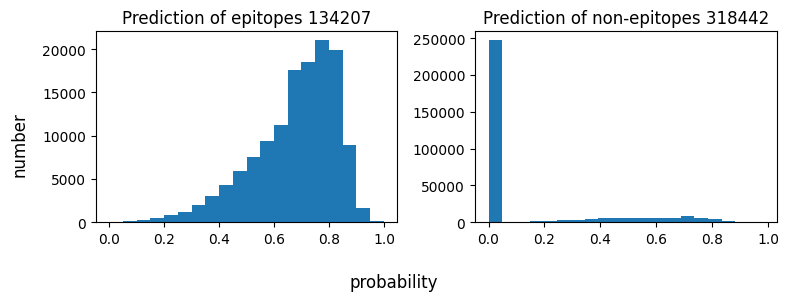

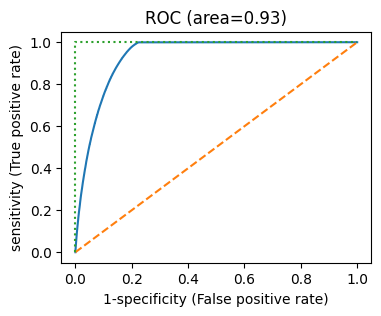

In [30]:
# evaluate model using test data
c.test()
c.plot_prob()
c.plot_roc()

In [32]:
# save entire model
c.save_model('../models/epitopes_ann_notCys_Val_Leu.keras')

<Sequential name=sequential_4, built=True>

### the remaining

In [33]:
def fn(x):
    if x['label'] == 1:
        seq = str(x['seq'])
        if ('C' not in seq) and 'V' in seq and 'L' in seq:
            return False
        return True
    return True
select = df.apply(fn, axis=1)
print(select.value_counts())

# keep epitopes without Cys, Val or Leu
sub_df = df.loc[select]
print(sub_df.shape)

True     2787990
False     670248
Name: count, dtype: int64
(2787990, 50)


In [34]:
# prepare 
c = MyAnn()
c.get_xy(sub_df)

X: (2787990, 48) float16
y: (2787990,) float16
labels: Counter({np.float16(0.0): 1592996, np.float16(1.0): 1194994})
train data: (1561274, 48) (1561274,)
validate data: (669118, 48) (669118,)
test data (557598, 48) (557598,)


In [35]:
# train model
c.declare_model()
c.train(epochs=10)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 512)            │        25,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,433 (290.75 KB)

 Trainable params: 74,433 (290.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
48790/48790 ━━━━━━━━━━━━━━━━━━━━ 99s 2ms/step - accuracy: 0.7035 - auc: 0.7791 - loss: 0.5418 - mse: 0.1877 - precision: 0.6460 - recall: 0.6826 - val_accuracy: 0.7316 - val_auc: 0.8115 - val_loss: 0.5098 - val_mse: 0.1744 - val_precision: 0.6728 - val_recall: 0.7283
Epoch 2/10
48790/48790 ━━━━━━━━━━━━━━━━━━━━ 101s 2ms/step - accuracy: 0.7280 - auc: 0.8072 - loss: 0.5160 - mse: 0.1766 - precision: 0.6638 - recall: 0.7413 - val_accuracy: 0.7388 - val_auc: 0.8205 - val_loss: 0.5019 - val_mse: 0.1710 - val_precision: 0.6701 - val_recall: 0.7702
Epoch 3/10
48790/48790 ━━━━━━━━━━━━━━━━━━━━ 97s 2ms/step - accuracy: 0.7350 - auc: 0.8147 - loss: 0.5086 - mse: 0.1734 - precision: 0.6713 - recall: 0.7470 - val_accuracy: 0.7424 - val_auc: 0.8244 - val_loss: 0.4974 - val_mse: 0.1692 - val_precision: 0.6807 - val_recall: 0.7521
Epoch 4/10
48790/48790 ━━━━━━━━━━━━━━━━━━━━ 94s 2ms/step - accuracy: 0.7374 - auc: 0.8175 - loss: 0.5056 - mse: 0.1721 - precision: 0.6736 - recall: 0.7493 -

,accuracy,auc,loss,mse,precision,recall,val_accuracy,val_auc,val_loss,val_mse,val_precision,val_recall
0,0.713342,0.790789,0.531227,0.183292,0.652801,0.707447,0.731588,0.811486,0.509803,0.174417,0.672816,0.728337
1,0.730209,0.809479,0.513798,0.175655,0.665651,0.744485,0.738783,0.820457,0.501853,0.170997,0.670055,0.770175
2,0.735343,0.815146,0.508119,0.173198,0.671703,0.748200,0.742394,0.824352,0.497415,0.169179,0.680722,0.752110
3,0.737807,0.817700,0.505547,0.172050,0.674533,0.750279,0.743144,0.825064,0.496614,0.168797,0.673860,0.777304
4,0.739151,0.819178,0.504112,0.171417,0.676446,0.750262,0.745701,0.826921,0.493609,0.167468,0.682514,0.761104
5,0.739958,0.820291,0.502940,0.170915,0.677895,0.749330,0.747181,0.828543,0.492636,0.167057,0.687046,0.753929
6,0.740852,0.821210,0.501950,0.170494,0.678672,0.750890,0.747272,0.829001,0.497164,0.168245,0.702032,0.713601
7,0.741468,0.822040,0.500970,0.170106,0.679691,0.750470,0.747227,0.829192,0.491782,0.166602,0.681278,0.771589
8,0.741916,0.822411,0.500766,0.169949,0.680113,0.751150,0.746357,0.829234,0.491557,0.166715,0.679722,0.772659
9,0.742316,0.822943,0.500060,0.169688,0.680828,0.750721,0.747287,0.829897,0.492186,0.166888,0.680692,0.773691


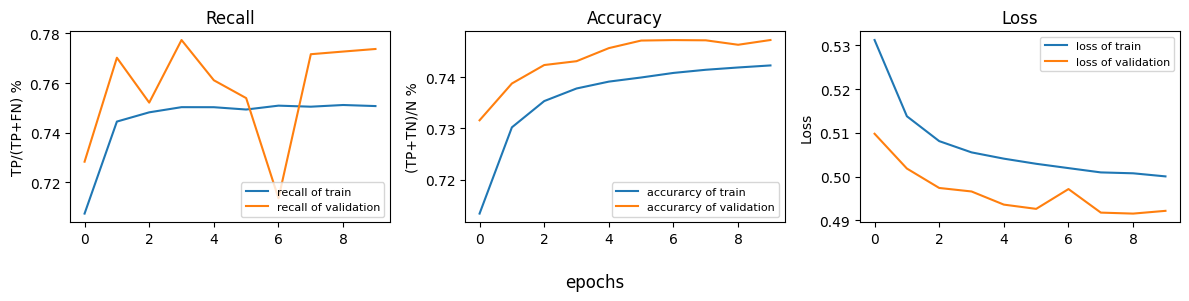

In [36]:
# evaluate model
c.plot_acc_recall()

17425/17425 ━━━━━━━━━━━━━━━━━━━━ 16s 902us/step - accuracy: 0.7468 - auc: 0.8301 - loss: 0.4920 - mse: 0.1668 - precision: 0.6801 - recall: 0.7729
{'accuracy': 0.7466382384300232, 'auc': 0.8295730352401733, 'loss': 0.4926412105560303, 'mse': 0.16704364120960236, 'precision': 0.6796656250953674, 'recall': 0.7727314829826355}
17425/17425 ━━━━━━━━━━━━━━━━━━━━ 7s 409us/step
[[0.4607665 ]
 [0.18850583]
 [0.27131468]]


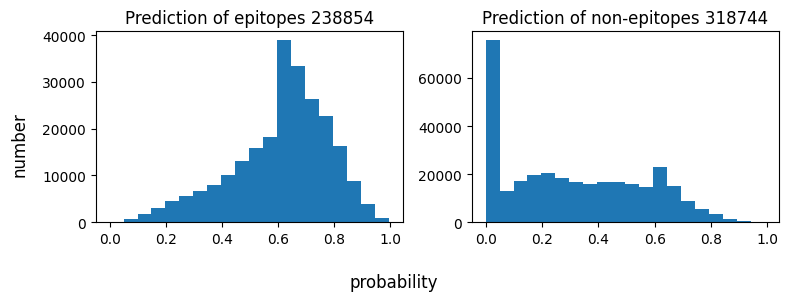

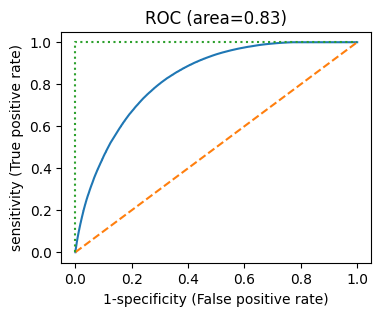

In [37]:
# evaluate model using test data
c.test()
c.plot_prob()
c.plot_roc()

In [39]:
# save entire model
c.save_model('../models/epitopes_ann_notCys_Val_Leu_remaining.keras')

<Sequential name=sequential_5, built=True>

## filter IV: 
- Cys not in seq and Leu in seq

### the one

In [52]:
def fn(x):
    if x['label'] == 1:
        seq = str(x['seq'])
        if ('C' not in seq) and 'L' in seq:
            return True
        return False
    return True
select = df.apply(fn, axis=1)
print(select.value_counts())

# keep epitopes having Val or Leu, and without Cys
sub_df = df.loc[select]
print(sub_df.shape)

True     2748684
False     709554
Name: count, dtype: int64
(2748684, 50)


In [53]:
# prepare 
c = MyAnn()
c.get_xy(sub_df)

X: (2748684, 48) float16
y: (2748684,) float16
labels: Counter({np.float16(0.0): 1592996, np.float16(1.0): 1155688})
train data: (1539262, 48) (1539262,)
validate data: (659685, 48) (659685,)
test data (549737, 48) (549737,)


In [54]:
# train model
c.declare_model()
c.train(epochs=10)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 512)            │        25,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,433 (290.75 KB)

 Trainable params: 74,433 (290.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
48102/48102 ━━━━━━━━━━━━━━━━━━━━ 96s 2ms/step - accuracy: 0.7572 - auc: 0.8462 - loss: 0.4381 - mse: 0.1521 - precision: 0.6671 - recall: 0.8421 - val_accuracy: 0.7715 - val_auc: 0.8622 - val_loss: 0.4221 - val_mse: 0.1454 - val_precision: 0.6786 - val_recall: 0.8678
Epoch 2/10
48102/48102 ━━━━━━━━━━━━━━━━━━━━ 84s 2ms/step - accuracy: 0.7700 - auc: 0.8592 - loss: 0.4258 - mse: 0.1467 - precision: 0.6819 - recall: 0.8479 - val_accuracy: 0.7765 - val_auc: 0.8664 - val_loss: 0.4194 - val_mse: 0.1441 - val_precision: 0.6914 - val_recall: 0.8465
Epoch 3/10
48102/48102 ━━━━━━━━━━━━━━━━━━━━ 86s 2ms/step - accuracy: 0.7724 - auc: 0.8616 - loss: 0.4234 - mse: 0.1457 - precision: 0.6861 - recall: 0.8449 - val_accuracy: 0.7774 - val_auc: 0.8677 - val_loss: 0.4175 - val_mse: 0.1433 - val_precision: 0.6876 - val_recall: 0.8630
Epoch 4/10
48102/48102 ━━━━━━━━━━━━━━━━━━━━ 86s 2ms/step - accuracy: 0.7738 - auc: 0.8628 - loss: 0.4223 - mse: 0.1451 - precision: 0.6882 - recall: 0.8432 - 

,accuracy,auc,loss,mse,precision,recall,val_accuracy,val_auc,val_loss,val_mse,val_precision,val_recall
0,0.762293,0.851939,0.432671,0.149823,0.671908,0.848734,0.771468,0.862244,0.422125,0.145398,0.678611,0.867764
1,0.769951,0.859403,0.425810,0.146730,0.682167,0.847289,0.776496,0.866396,0.419407,0.144059,0.691438,0.846509
2,0.772408,0.861662,0.423700,0.145752,0.686427,0.843866,0.777377,0.867704,0.417546,0.143332,0.687560,0.863001
3,0.773627,0.862605,0.422844,0.145342,0.688483,0.842459,0.779705,0.868493,0.415184,0.142286,0.704150,0.821547
4,0.774216,0.863397,0.422023,0.144970,0.690456,0.838662,0.780037,0.868919,0.415526,0.142355,0.713271,0.797917
5,0.775058,0.864044,0.421471,0.144696,0.691896,0.837715,0.779172,0.869263,0.416050,0.142639,0.687882,0.869735
6,0.775634,0.864474,0.421034,0.144504,0.692729,0.837562,0.781679,0.869943,0.413707,0.141640,0.703711,0.830908
7,0.775830,0.864916,0.420512,0.144281,0.693556,0.835817,0.782378,0.870749,0.413717,0.141595,0.710282,0.815263
8,0.776218,0.865121,0.420381,0.144206,0.694436,0.834738,0.781437,0.870793,0.412744,0.141258,0.700229,0.840164
9,0.776534,0.865433,0.420054,0.144088,0.694750,0.835110,0.778796,0.871036,0.414774,0.142164,0.683515,0.883117


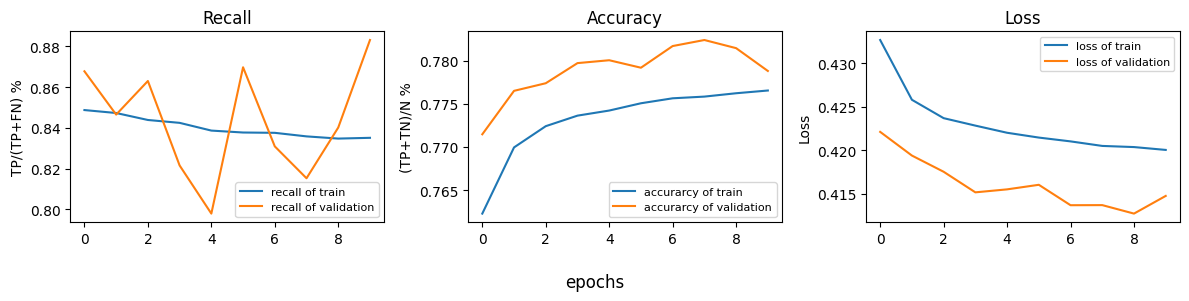

In [55]:
# evaluate model
c.plot_acc_recall()

17180/17180 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - accuracy: 0.7778 - auc: 0.8692 - loss: 0.4169 - mse: 0.1430 - precision: 0.6825 - recall: 0.8829   
{'accuracy': 0.7777591943740845, 'auc': 0.86965411901474, 'loss': 0.41643598675727844, 'mse': 0.142826646566391, 'precision': 0.6821994185447693, 'recall': 0.8835003972053528}
17180/17180 ━━━━━━━━━━━━━━━━━━━━ 6s 366us/step
[[0.6380241 ]
 [0.5679207 ]
 [0.69069284]]


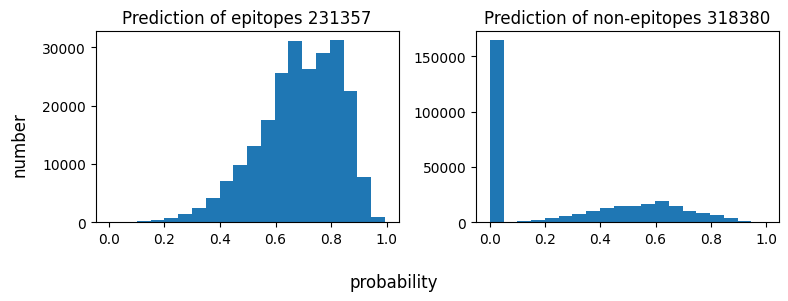

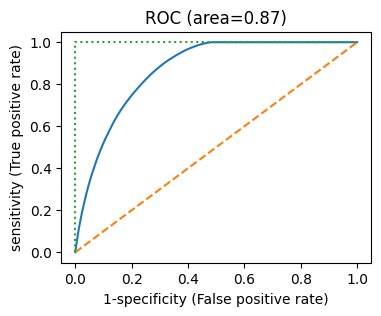

In [56]:
# evaluate model using test data
c.test()
c.plot_prob()
c.plot_roc()

In [57]:
# save entire model
c.save_model('../models/epitopes_ann_notCys_Leu.keras')

<Sequential name=sequential_8, built=True>

### the remaining

In [58]:
def fn(x):
    if x['label'] == 1:
        seq = str(x['seq'])
        if ('C' not in seq) and 'L' in seq:
            return False
        return True
    return True
select = df.apply(fn, axis=1)
print(select.value_counts())

# keep epitopes without Cys, Val or Leu
sub_df = df.loc[select]
print(sub_df.shape)

True     2302550
False    1155688
Name: count, dtype: int64
(2302550, 50)


In [59]:
# prepare 
c = MyAnn()
c.get_xy(sub_df)

X: (2302550, 48) float16
y: (2302550,) float16
labels: Counter({np.float16(0.0): 1592996, np.float16(1.0): 709554})
train data: (1289428, 48) (1289428,)
validate data: (552612, 48) (552612,)
test data (460510, 48) (460510,)


In [60]:
# train model
c.declare_model()
c.train(epochs=10)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 512)            │        25,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,433 (290.75 KB)

 Trainable params: 74,433 (290.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
40295/40295 ━━━━━━━━━━━━━━━━━━━━ 80s 2ms/step - accuracy: 0.7816 - auc: 0.8591 - loss: 0.4076 - mse: 0.1403 - precision: 0.6472 - recall: 0.6446 - val_accuracy: 0.8031 - val_auc: 0.8816 - val_loss: 0.3817 - val_mse: 0.1299 - val_precision: 0.6571 - val_recall: 0.7531
Epoch 2/10
40295/40295 ━━━━━━━━━━━━━━━━━━━━ 73s 2ms/step - accuracy: 0.8024 - auc: 0.8794 - loss: 0.3845 - mse: 0.1306 - precision: 0.6651 - recall: 0.7238 - val_accuracy: 0.8124 - val_auc: 0.8894 - val_loss: 0.3704 - val_mse: 0.1251 - val_precision: 0.6725 - val_recall: 0.7608
Epoch 3/10
40295/40295 ━━━━━━━━━━━━━━━━━━━━ 76s 2ms/step - accuracy: 0.8086 - auc: 0.8850 - loss: 0.3776 - mse: 0.1276 - precision: 0.6718 - recall: 0.7423 - val_accuracy: 0.8147 - val_auc: 0.8926 - val_loss: 0.3691 - val_mse: 0.1244 - val_precision: 0.6691 - val_recall: 0.7871
Epoch 4/10
40295/40295 ━━━━━━━━━━━━━━━━━━━━ 75s 2ms/step - accuracy: 0.8113 - auc: 0.8873 - loss: 0.3748 - mse: 0.1263 - precision: 0.6760 - recall: 0.7476 - 

,accuracy,auc,loss,mse,precision,recall,val_accuracy,val_auc,val_loss,val_mse,val_precision,val_recall
0,0.789756,0.867359,0.398352,0.136556,0.654959,0.672549,0.803088,0.881570,0.381747,0.129867,0.657117,0.753121
1,0.804160,0.880862,0.382608,0.129792,0.666748,0.729638,0.812353,0.889420,0.370409,0.125142,0.672460,0.760836
2,0.809296,0.885513,0.376860,0.127303,0.672743,0.743075,0.814718,0.892584,0.369067,0.124403,0.669148,0.787114
3,0.811881,0.887625,0.374240,0.126140,0.676426,0.747614,0.817445,0.893340,0.365955,0.123188,0.692734,0.731064
4,0.813323,0.889090,0.372386,0.125345,0.678630,0.749684,0.817597,0.894423,0.363852,0.122386,0.678783,0.773178
5,0.814564,0.889941,0.371083,0.124822,0.680409,0.751819,0.819573,0.895752,0.361538,0.121431,0.692503,0.744136
6,0.815220,0.890536,0.370473,0.124520,0.681570,0.752284,0.818325,0.895335,0.363619,0.122250,0.680092,0.773502
7,0.815022,0.890880,0.369962,0.124316,0.680740,0.753604,0.817376,0.896240,0.362966,0.122080,0.669331,0.803549
8,0.815783,0.891229,0.369498,0.124119,0.681719,0.755257,0.820583,0.896885,0.360494,0.120785,0.687953,0.763147
9,0.816385,0.891778,0.368790,0.123813,0.683212,0.754381,0.821448,0.897155,0.359518,0.120468,0.690096,0.761994


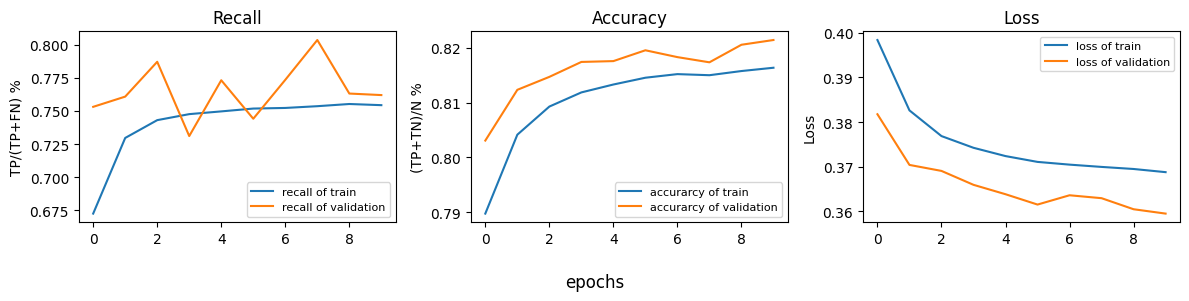

In [61]:
# evaluate model
c.plot_acc_recall()

14391/14391 ━━━━━━━━━━━━━━━━━━━━ 14s 950us/step - accuracy: 0.8206 - auc: 0.8964 - loss: 0.3607 - mse: 0.1210 - precision: 0.6888 - recall: 0.7611
{'accuracy': 0.8204729557037354, 'auc': 0.8965423703193665, 'loss': 0.3606483042240143, 'mse': 0.12094195187091827, 'precision': 0.6893995404243469, 'recall': 0.7592386603355408}
14391/14391 ━━━━━━━━━━━━━━━━━━━━ 6s 377us/step
[[0.08491389]
 [0.3892508 ]
 [0.80218446]]


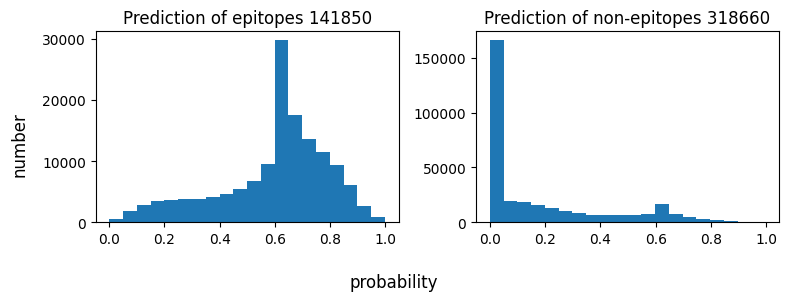

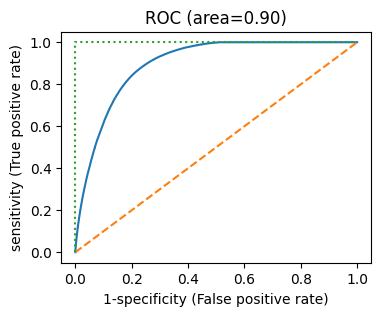

In [62]:
# evaluate model using test data
c.test()
c.plot_prob()
c.plot_roc()

In [63]:
# save entire model
c.save_model('../models/epitopes_ann_notCys_Leu_remaining.keras')

<Sequential name=sequential_9, built=True>

## filter V: 
- Cys not in seq or Leu in seq

### the one

In [64]:
def fn(x):
    if x['label'] == 1:
        seq = str(x['seq'])
        if ('C' not in seq) or 'L' in seq:
            return True
        return False
    return True
select = df.apply(fn, axis=1)
print(select.value_counts())

# keep epitopes having Val or Leu, and without Cys
sub_df = df.loc[select]
print(sub_df.shape)

True     3390991
False      67247
Name: count, dtype: int64
(3390991, 50)


In [65]:
# prepare 
c = MyAnn()
c.get_xy(sub_df)

X: (3390991, 48) float16
y: (3390991,) float16
labels: Counter({np.float16(1.0): 1797995, np.float16(0.0): 1592996})
train data: (1898954, 48) (1898954,)
validate data: (813838, 48) (813838,)
test data (678199, 48) (678199,)


In [66]:
# train model
c.declare_model()
c.train(epochs=10)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 512)            │        25,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,433 (290.75 KB)

 Trainable params: 74,433 (290.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
59343/59343 ━━━━━━━━━━━━━━━━━━━━ 119s 2ms/step - accuracy: 0.6729 - auc: 0.7326 - loss: 0.5967 - mse: 0.2067 - precision: 0.6609 - recall: 0.7847 - val_accuracy: 0.6979 - val_auc: 0.7639 - val_loss: 0.5698 - val_mse: 0.1954 - val_precision: 0.6790 - val_recall: 0.8158
Epoch 2/10
59343/59343 ━━━━━━━━━━━━━━━━━━━━ 116s 2ms/step - accuracy: 0.6948 - auc: 0.7588 - loss: 0.5756 - mse: 0.1975 - precision: 0.6790 - recall: 0.8050 - val_accuracy: 0.7032 - val_auc: 0.7719 - val_loss: 0.5627 - val_mse: 0.1924 - val_precision: 0.6812 - val_recall: 0.8274
Epoch 3/10
59343/59343 ━━━━━━━━━━━━━━━━━━━━ 118s 2ms/step - accuracy: 0.7004 - auc: 0.7659 - loss: 0.5695 - mse: 0.1948 - precision: 0.6854 - recall: 0.8028 - val_accuracy: 0.7084 - val_auc: 0.7749 - val_loss: 0.5605 - val_mse: 0.1909 - val_precision: 0.6968 - val_recall: 0.7966
Epoch 4/10
59343/59343 ━━━━━━━━━━━━━━━━━━━━ 107s 2ms/step - accuracy: 0.7030 - auc: 0.7690 - loss: 0.5669 - mse: 0.1937 - precision: 0.6887 - recall: 0.802

,accuracy,auc,loss,mse,precision,recall,val_accuracy,val_auc,val_loss,val_mse,val_precision,val_recall
0,0.680813,0.742591,0.588785,0.203351,0.666538,0.796033,0.697926,0.763885,0.569808,0.195410,0.679040,0.815837
1,0.696712,0.761055,0.573671,0.196647,0.680948,0.804921,0.703173,0.771854,0.562699,0.192351,0.681158,0.827419
2,0.701082,0.766764,0.568703,0.194491,0.686483,0.802554,0.708388,0.774888,0.560519,0.190946,0.696780,0.796617
3,0.703430,0.769308,0.566553,0.193511,0.689362,0.801729,0.708962,0.777382,0.557773,0.190149,0.693461,0.808363
4,0.704546,0.771003,0.565040,0.192868,0.690839,0.801043,0.710967,0.778890,0.556784,0.189589,0.698938,0.798962
5,0.705463,0.772219,0.563967,0.192395,0.692241,0.799928,0.710270,0.779611,0.556805,0.189580,0.701132,0.790438
6,0.706324,0.772980,0.563293,0.192083,0.693327,0.799595,0.711935,0.780383,0.554785,0.188814,0.693208,0.819189
7,0.706552,0.773672,0.562649,0.191803,0.693549,0.799704,0.712593,0.782425,0.553755,0.188410,0.692618,0.823226
8,0.707209,0.774405,0.562033,0.191513,0.694129,0.800199,0.709501,0.781513,0.558028,0.190181,0.682972,0.843673
9,0.707639,0.774731,0.561613,0.191362,0.694686,0.799994,0.710456,0.781182,0.556331,0.189523,0.684765,0.841019


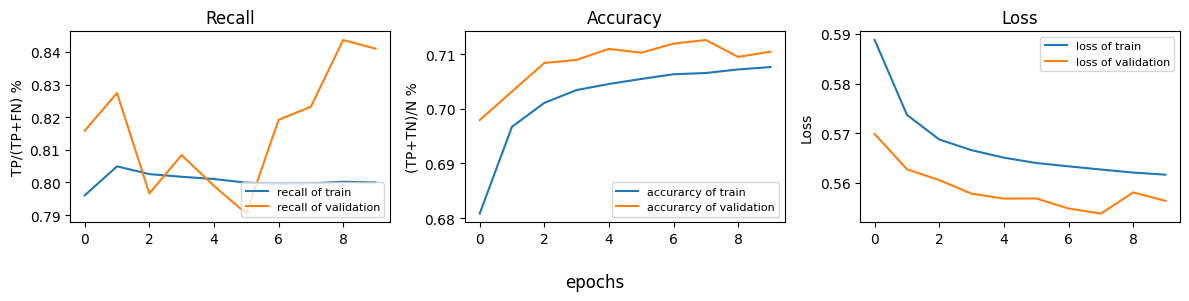

In [67]:
# evaluate model
c.plot_acc_recall()

21194/21194 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step - accuracy: 0.7111 - auc: 0.7818 - loss: 0.5559 - mse: 0.1893 - precision: 0.6854 - recall: 0.8423  
{'accuracy': 0.7103092074394226, 'auc': 0.7811357975006104, 'loss': 0.556328296661377, 'mse': 0.1894911378622055, 'precision': 0.6849860548973083, 'recall': 0.8411619663238525}
21194/21194 ━━━━━━━━━━━━━━━━━━━━ 8s 369us/step
[[0.68086004]
 [0.8362349 ]
 [0.32417545]]


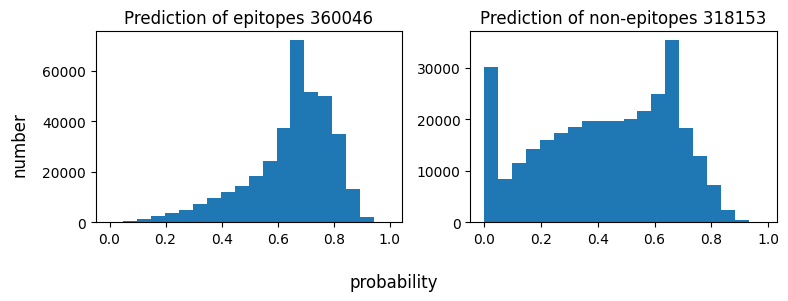

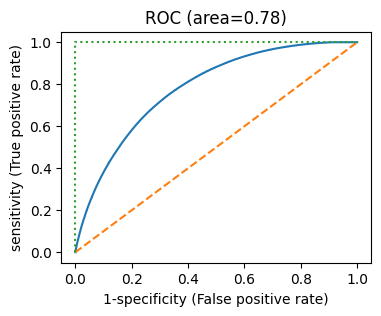

In [68]:
# evaluate model using test data
c.test()
c.plot_prob()
c.plot_roc()

In [69]:
# save entire model
c.save_model('../models/epitopes_ann_notCys_orLeu.keras')

<Sequential name=sequential_10, built=True>

### the remaining

In [70]:
def fn(x):
    if x['label'] == 1:
        seq = str(x['seq'])
        if ('C' not in seq) or 'L' in seq:
            return False
        return True
    return True
select = df.apply(fn, axis=1)
print(select.value_counts())

# keep epitopes without Cys, Val or Leu
sub_df = df.loc[select]
print(sub_df.shape)

False    1797995
True     1660243
Name: count, dtype: int64
(1660243, 50)


In [71]:
# prepare 
c = MyAnn()
c.get_xy(sub_df)

X: (1660243, 48) float16
y: (1660243,) float16
labels: Counter({np.float16(0.0): 1592996, np.float16(1.0): 67247})
train data: (929735, 48) (929735,)
validate data: (398459, 48) (398459,)
test data (332049, 48) (332049,)


In [72]:
# train model
c.declare_model()
c.train(epochs=10)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 512)            │        25,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,433 (290.75 KB)

 Trainable params: 74,433 (290.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
29055/29055 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step - accuracy: 0.9666 - auc: 0.9757 - loss: 0.0701 - mse: 0.0229 - precision: 0.6361 - recall: 0.4293 - val_accuracy: 0.9701 - val_auc: 0.9829 - val_loss: 0.0628 - val_mse: 0.0207 - val_precision: 0.7129 - val_recall: 0.4396
Epoch 2/10
29055/29055 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step - accuracy: 0.9701 - auc: 0.9816 - loss: 0.0633 - mse: 0.0208 - precision: 0.6681 - recall: 0.5198 - val_accuracy: 0.9711 - val_auc: 0.9839 - val_loss: 0.0611 - val_mse: 0.0201 - val_precision: 0.7050 - val_recall: 0.4952
Epoch 3/10
29055/29055 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - accuracy: 0.9713 - auc: 0.9826 - loss: 0.0620 - mse: 0.0202 - precision: 0.6808 - recall: 0.5535 - val_accuracy: 0.9727 - val_auc: 0.9845 - val_loss: 0.0593 - val_mse: 0.0193 - val_precision: 0.6861 - val_recall: 0.6023
Epoch 4/10
29055/29055 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - accuracy: 0.9717 - auc: 0.9831 - loss: 0.0615 - mse: 0.0200 - precision: 0.6788 - recall: 0.5833 - 

,accuracy,auc,loss,mse,precision,recall,val_accuracy,val_auc,val_loss,val_mse,val_precision,val_recall
0,0.968392,0.979649,0.066059,0.021802,0.657081,0.464042,0.970085,0.982929,0.062849,0.020704,0.712881,0.439619
1,0.970339,0.981984,0.063056,0.020679,0.671226,0.528809,0.971116,0.983949,0.061094,0.020056,0.705012,0.495174
2,0.971120,0.982505,0.062219,0.020349,0.677025,0.552666,0.972690,0.984508,0.059306,0.019331,0.686143,0.602264
3,0.971550,0.982892,0.061634,0.020102,0.677747,0.571202,0.972685,0.984704,0.060396,0.019651,0.692308,0.587973
4,0.971577,0.982940,0.061555,0.020054,0.679840,0.567548,0.972788,0.984447,0.059642,0.019298,0.665444,0.662027
5,0.971663,0.982938,0.061383,0.019963,0.678248,0.575306,0.972436,0.984839,0.058984,0.019225,0.703704,0.553638
6,0.971767,0.983206,0.060978,0.019816,0.682087,0.571175,0.972537,0.984403,0.059335,0.019232,0.704153,0.557040
7,0.971870,0.983201,0.060759,0.019707,0.684047,0.571440,0.973131,0.985211,0.058493,0.018985,0.674466,0.652685
8,0.971799,0.983204,0.060885,0.019730,0.680439,0.576497,0.972680,0.985088,0.058333,0.018969,0.691732,0.589025
9,0.972077,0.983396,0.060653,0.019637,0.684991,0.578722,0.973167,0.985195,0.059026,0.019216,0.689290,0.616370


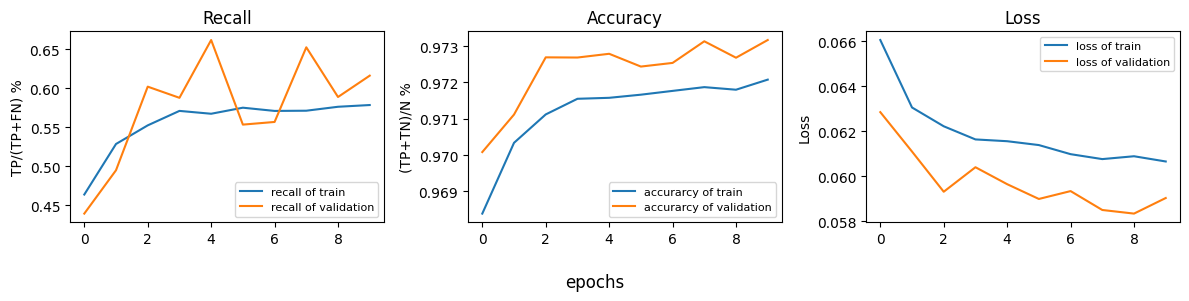

In [73]:
# evaluate model
c.plot_acc_recall()

10377/10377 ━━━━━━━━━━━━━━━━━━━━ 10s 958us/step - accuracy: 0.9721 - auc: 0.9845 - loss: 0.0599 - mse: 0.0197 - precision: 0.6784 - recall: 0.6028
{'accuracy': 0.9726185202598572, 'auc': 0.9846624732017517, 'loss': 0.059075407683849335, 'mse': 0.019331296905875206, 'precision': 0.6773272752761841, 'recall': 0.6059172749519348}
10377/10377 ━━━━━━━━━━━━━━━━━━━━ 4s 416us/step
[[0.]
 [0.]
 [0.]]


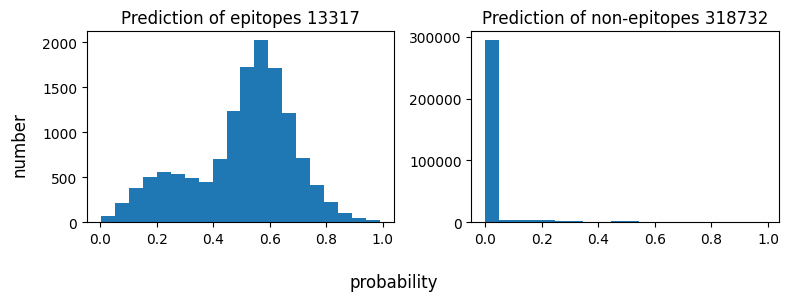

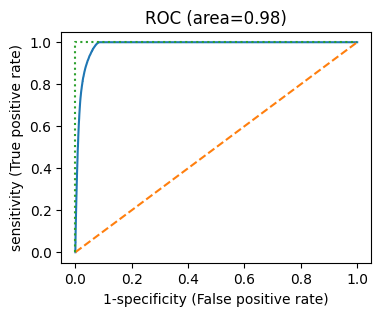

In [74]:
# evaluate model using test data
c.test()
c.plot_prob()
c.plot_roc()

In [75]:
# save entire model
c.save_model('../models/epitopes_ann_notCys_orLeu_remaining.keras')

<Sequential name=sequential_11, built=True>